In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# State Manual Update 

- LangGraph은 중간 단계의 State를 수동으로 업데이트 할 수 있는 방안을 제공함 
- 이를 통해 에이전트 행동을 수정하여 경로를 제어할 수 있음 
- 또한 에이전트의 실수를 수정하거나, 대체 경로를 탐색하는 것처럼 특정 목표에 따라 에이전트의 동작을 변경할 때 유용함 

## Agent 설계

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph

/Users/a09758/KDT/AI-Agent-대중소상생/skala_gai/.venv1/lib/python3.11/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


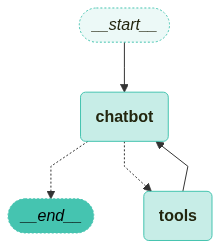

In [4]:
########## 1. State ##########
class State(TypedDict):
    messages: Annotated[list, add_messages]


########## 2. TOOLS ##########
# 도구 초기화
tool = TavilySearch(max_results=3)

# 도구 목록 정의
tools = [tool]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# LLM + 도구 
llm_with_tools = llm.bind_tools(tools)


########## 3. NODE ##########
# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Conditional Edge
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)


########## 4. EDGE ##########
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


########## 5. MEMORY ##########
memory = MemorySaver()


########## 6. COMPILE  ##########
graph = graph_builder.compile(checkpointer=memory)


########## 7. VISUALIZE ##########
visualize_graph(graph)

In [5]:
from langchain_core.runnables import RunnableConfig

In [6]:
question = "LangGraph 가 무엇인지 조사하여 알려주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    configurable={"thread_id": "001"},  
)

**channels**

- LangGraph 내부에서 노드 간 데이터가 흐르는 경로(통로) 
- 각 노드의 입력과 출력을 연결하는 데이터 이동 경로 

In [7]:
# 그래프 채널 목록 출력
list(graph.channels)

['messages', '__start__', 'branch:to:chatbot', 'branch:to:tools']

## interrupt 상태 확인

In [8]:
# 그래프 스트림 호출
# 중단 지점(interrupt_before=[“tools”])에서 중간 상태 확인
events = graph.stream(
    input=input, config=config, interrupt_before=["tools"], stream_mode="values"
)

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_cxbuVl3tfpNPUcVfB73tNQXK)
 Call ID: call_cxbuVl3tfpNPUcVfB73tNQXK
  Args:
    query: LangGraph


In [9]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 가장 최근 메시지 추출
last_message = snapshot.values["messages"][-1]

# 메시지 출력
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_cxbuVl3tfpNPUcVfB73tNQXK)
 Call ID: call_cxbuVl3tfpNPUcVfB73tNQXK
  Args:
    query: LangGraph


## 도구 결과 수동 수정

- `TavilySearch` 도구에서 검색 결과 수정하여 새로운 ToolMessage 생성
- tool_call_id를 기존 메시지에서 추출 후 동일 ID로 새 메시지 생성
- 그래프 상태 업데이트 (graph.update_state)로 반영
- 이후 흐름 계속 실행

In [10]:
modified_search_result = """[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요."""

print(modified_search_result)

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


In [11]:
# 수정하고자 하는 `ToolMessage` 의 `tool_call_id` 추출
tool_call_id = last_message.tool_calls[0]["id"]
print(tool_call_id)

call_cxbuVl3tfpNPUcVfB73tNQXK


**메시지 타입**

- HumanMessage : 사용자 입력 전달 
- AIMessage : LLM의 텍스트 응답 메시지, 일반적인 대화 응답 
- SystemMessage : 대화 설정 또는 시스템 프롬프트 
- ToolMessage : 도구 실행 결과 메시지

In [12]:
from langchain_core.messages import AIMessage, ToolMessage

In [13]:
new_messages = [
    # LLM API의 도구 호출과 일치하는 ToolMessage 필요
    ToolMessage(
        content=modified_search_result,
        tool_call_id=tool_call_id,
    ),
    # LLM의 응답에 직접적으로 내용 추가
    # AIMessage(content=modified_search_result),
]

new_messages[-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


## StateGraph의 `update_state` 

- `update_state` : 주어진 값으로 그래프의 상태를 업데이트
- 마치 `as_node`에서 값이 온 것처럼 동작함

**매개변수**

- `config` (RunnableConfig): 실행 구성
- `values` (Optional[Union[dict[str, Any], Any]]): 업데이트할 값들
- `as_node` (Optional[str]): 값의 출처로 간주할 노드 이름. 기본값은 None

**반환값**

- RunnableConfig

**주요 기능**

1. 체크포인터를 통해 이전 상태를 로드하고 새로운 상태를 저장
2. 서브그래프에 대한 상태 업데이트를 처리
3. `as_node`가 지정되지 않은 경우, 마지막으로 상태를 업데이트한 노드를 찾음
4. 지정된 노드의 writer들을 실행하여 상태를 업데이트
5. 업데이트된 상태를 체크포인트에 저장

**주요 로직**

1. 체크포인터를 확인하고, 없으면 ValueError를 발생시킴
2. 서브그래프에 대한 업데이트인 경우, 해당 서브그래프의 `update_state` 메서드를 호출
3. 이전 체크포인트를 로드하고, 필요한 경우 `as_node`를 결정
4. 지정된 노드의 writer들을 사용하여 상태를 업데이트
5. 업데이트된 상태를 새로운 체크포인트로 저장

**참고**

- 이 메서드는 그래프의 상태를 수동으로 업데이트할 때 사용
- 체크포인터를 사용하여 상태의 버전 관리와 지속성 보장
- `as_node`를 지정하지 않으면 자동으로 결정되지만, 모호한 경우 오류가 발생할 수 있음
- 상태 업데이트 중 SharedValues에 쓰기 작업은 허용되지 않음

In [14]:
graph.update_state(
    # 업데이트할 상태 지정
    config,
    # 제공할 업데이트된 값. `State`의 메시지는 "추가 전용"으로 기존 상태에 추가됨
    {"messages": new_messages},
    as_node="tools",
)

print("(최근 1개의 메시지 출력)\n")
print(graph.get_state(config).values["messages"][-1])

(최근 1개의 메시지 출력)

content='[수정된 웹 검색 결과] \nLangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.\nLangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.\n\n자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과\n[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.' id='7a5ee578-3449-494b-8492-eabdbdc4b10c' tool_call_id='call_cxbuVl3tfpNPUcVfB73tNQXK'


In [15]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [16]:
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. 이 라이브러리는 LLM(대형 언어 모델)을 활용하여 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능 등을 제공합니다.

더 자세한 정보와 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)과 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785)에서 확인할 수 있습니다.


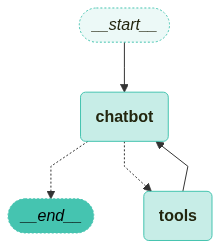

In [17]:
visualize_graph(graph)

In [18]:
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_cxbuVl3tfpNPUcVfB73tNQXK)
 Call ID: call_cxbuVl3tfpNPUcVfB73tNQXK
  Args:
    query: LangGraph
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. 이 라이브러리는 LLM(대형 언어 모델)을 활용하여 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능 등을 제공합니다.

더 자세한 정보와 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)과 [랭체인 한국어 튜토리얼](

In [19]:
# 다음 상태 출력
print(snapshot.next)

()


## Interrupt 후 메시지 상태 업데이트 

- `TavilySearch` 도구에서 검색 쿼리 수정
- `thread_id` : 랜덤한 해시값을 생성하는 `generate_random_hash` 함수를 사용하여 적용 

In [20]:
from langchain_teddynote.graphs import generate_random_hash

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

thread_id: 429de3


In [21]:
question = "LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!"

input = State(messages=[("user", question)])

config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_uR6h7jVBHy2hObv0r1l0JxYF)
 Call ID: call_uR6h7jVBHy2hObv0r1l0JxYF
  Args:
    query: LangGraph


In [22]:
# config 를 복사
config_copy = config.copy()

In [23]:
from langchain_core.messages import AIMessage

# 스냅샷 상태 
snapshot = graph.get_state(config)

# messages 의 마지막 메시지 
existing_message = snapshot.values["messages"][-1]

# 메시지 ID 출력
print("Message ID", existing_message.id)

Message ID run--b458ab8c-e1ae-40c7-9f7b-7830ea3e40cb-0


In [24]:
# 첫 번째 도구 호출 출력
print(existing_message.tool_calls[0])

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph'}, 'id': 'call_uR6h7jVBHy2hObv0r1l0JxYF', 'type': 'tool_call'}


In [25]:
# tool_calls 를 복사하여 새로운 도구 호출 생성
new_tool_call = existing_message.tool_calls[0].copy()

# 쿼리 매개변수 업데이트
new_tool_call["args"] = {"query": "LangGraph Studio"}
new_tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph Studio'},
 'id': 'call_uR6h7jVBHy2hObv0r1l0JxYF',
 'type': 'tool_call'}

In [26]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    id=existing_message.id,  # ID는 메시지를 상태에 추가하는 대신 교체하는 방법으로 처리 (별5개)
)

print(new_message.id)

run--b458ab8c-e1ae-40c7-9f7b-7830ea3e40cb-0


In [27]:
# 수정한 메시지 출력
new_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_uR6h7jVBHy2hObv0r1l0JxYF)
 Call ID: call_uR6h7jVBHy2hObv0r1l0JxYF
  Args:
    query: LangGraph Studio


In [28]:
# 업데이트된 도구 호출 출력
print(new_message.tool_calls[0])

# 메시지 ID 출력
print("\nMessage ID", new_message.id)

# 상태 업데이트
graph.update_state(config, {"messages": [new_message]})

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph Studio'}, 'id': 'call_uR6h7jVBHy2hObv0r1l0JxYF', 'type': 'tool_call'}

Message ID run--b458ab8c-e1ae-40c7-9f7b-7830ea3e40cb-0


{'configurable': {'thread_id': '429de3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f052f87-712d-600e-8002-7f65f41b3ec7'}}

In [29]:
# 마지막 메시지의 도구 호출 가져오기
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph Studio'},
  'id': 'call_uR6h7jVBHy2hObv0r1l0JxYF',
  'type': 'tool_call'}]

In [30]:
# 그래프 스트림에서 이벤트 수신
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_uR6h7jVBHy2hObv0r1l0JxYF)
 Call ID: call_uR6h7jVBHy2hObv0r1l0JxYF
  Args:
    query: LangGraph Studio
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "LangGraph Studio", "url": "https://langchain-ai.lang.chat/langgraph/concepts/langgraph_studio/", "content": "LangGraph Studio is a specialized agent IDE that enables visualization, interaction, and debugging of agentic systems that implement the LangGraph Server API protocol. Studio also integrates with LangSmith to enable tracing, evaluation, and prompt engineering. Features¶ Key features of LangGraph Studio: Visualize your graph architecture", "score": 0.95176035, "raw_content": "![logo](../../static/wordmark_dark.svg)\n![logo](../../static/wordmark_light.svg)\n![logo](../../static/wordmark_dark.svg)\n![logo](../../static/wordmark_light.svg)\n\n# Lang

In [31]:
# 이벤트 스트림 생성
events = graph.stream(
    {
        "messages": (
            "user",
            "내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 답변해 주세요. 출처를 반드시 포함해 주세요.",
        )
    },
    config,
    stream_mode="values",
)

# 메시지 이벤트 처리
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 답변해 주세요. 출처를 반드시 포함해 주세요.
================================== Ai Message ==================================

당신이 지금까지 배운 LangGraph에 대한 내용은 다음과 같습니다:

1. **LangGraph Studio**: LangGraph Studio는 LangGraph Server API 프로토콜을 구현하는 에이전트 시스템을 시각화하고 상호작용하며 디버깅할 수 있는 전문 IDE입니다. 이 스튜디오는 LangSmith와 통합되어 있어, 에이전트의 실행을 추적하고 평가하며 프롬프트 엔지니어링을 지원합니다. LangGraph Studio는 두 가지 모드를 지원합니다:
   - **Graph Mode**: 에이전트의 실행에 대한 자세한 정보를 제공하며, 노드 탐색, 중간 상태 및 LangSmith 통합을 포함합니다.
   - **Chat Mode**: 비즈니스 사용자와 채팅 전용 에이전트를 테스트하는 데 유용한 간단한 UI를 제공합니다. [자세한 내용은 여기에서 확인하세요.](https://langchain-ai.lang.chat/langgraph/concepts/langgraph_studio/)

2. **GitHub Repository**: LangGraph Studio의 소스 코드와 문서가 포함된 GitHub 리포지토리입니다. 이곳에서는 설치 방법, 사용법 및 기여 방법에 대한 정보를 찾을 수 있습니다. [GitHub에서 확인하기](https://github.com/langchain-ai/langgraph-studio)

3. **LangGraph 소개**: LangGraph는 에이전트 기반 사용자 경험을 설계하고, 애플리케이션을 신속하게 배포 및 확장할 수 있는 API

In [32]:
# 최종 응답 
# 최종 상태에서 `messages` 의 마지막 메시지로 확인 
graph.get_state(config).values["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신이 지금까지 배운 LangGraph에 대한 내용은 다음과 같습니다:

1. **LangGraph Studio**: LangGraph Studio는 LangGraph Server API 프로토콜을 구현하는 에이전트 시스템을 시각화하고 상호작용하며 디버깅할 수 있는 전문 IDE입니다. 이 스튜디오는 LangSmith와 통합되어 있어, 에이전트의 실행을 추적하고 평가하며 프롬프트 엔지니어링을 지원합니다. LangGraph Studio는 두 가지 모드를 지원합니다:
   - **Graph Mode**: 에이전트의 실행에 대한 자세한 정보를 제공하며, 노드 탐색, 중간 상태 및 LangSmith 통합을 포함합니다.
   - **Chat Mode**: 비즈니스 사용자와 채팅 전용 에이전트를 테스트하는 데 유용한 간단한 UI를 제공합니다. [자세한 내용은 여기에서 확인하세요.](https://langchain-ai.lang.chat/langgraph/concepts/langgraph_studio/)

2. **GitHub Repository**: LangGraph Studio의 소스 코드와 문서가 포함된 GitHub 리포지토리입니다. 이곳에서는 설치 방법, 사용법 및 기여 방법에 대한 정보를 찾을 수 있습니다. [GitHub에서 확인하기](https://github.com/langchain-ai/langgraph-studio)

3. **LangGraph 소개**: LangGraph는 에이전트 기반 사용자 경험을 설계하고, 애플리케이션을 신속하게 배포 및 확장할 수 있는 API를 제공합니다. LangGraph 플랫폼은 에이전트 UX를 구축하기 위한 의견이 반영된 API와 통합 개발자 스튜디오를 제공합니다. LangGraph는 대화형 에이전트, 복잡한 작업 자동화 및 사용자 맞춤형 LLM 기반 경험을 구축하는 데 필요한 기반을

## Replay

- 지난 스냅샷을 확인 후 특정 노드로 되돌아가, State를 수정한 뒤 해당 노드부터 다시 진행

In [33]:
to_replay_state = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):

    messages = state.values["messages"]

    if len(messages) > 0:
        print(state.values["messages"][-1].id)
        # 메시지 수 및 다음 상태 출력
        print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
        print("-" * 80)
        # 특정 상태 선택 기준: 채팅 메시지 수
        if len(state.values["messages"]) == 2:
            # 특정 메시지 ID 선택
            to_replay_state = state

run--677ada2a-82e9-4699-8ccd-7edf30fdac63-0
메시지 수:  6 다음 노드:  ()
--------------------------------------------------------------------------------
c04622ca-489e-4bd0-81d7-4cf3703f5d65
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run--cd009398-d88b-41ab-a801-dcae15d7cdcc-0
메시지 수:  4 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------
run--cd009398-d88b-41ab-a801-dcae15d7cdcc-0
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
2b6076c2-5947-4bb8-9c45-dd37842639a6
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run--b458ab8c-e1ae-40c7-9f7b-7830ea3e40cb-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
run--b458ab8c-e1ae-40c7-9f7b-7830ea3e40cb-0
메시지 수:  2 다음 노드:  ('tools',)
-------------------------

In [34]:
from langchain_teddynote.messages import display_message_tree

# 선택한 메시지 가져오기
existing_message = to_replay_state.values["messages"][-1]

# 메시지 트리 출력
display_message_tree(existing_message)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_uR6h7jVBHy2hObv0r1l0JxYF"
                function: {"arguments": "{"query":"LangGraph"}", "name": "tavily_web_search"}
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 18
            prompt_tokens: 110
            total_tokens: 128
            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
        model_name: "gpt-4o-mini-2024-07-18"
        system_fingerprint: "fp_62a23a81ef"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run--b458ab8c-e1ae-40c7-9f7b-7830ea3e40cb-0"
    example: False
    tool_calls:
        index [0]
            name: "tavily_web_search"
            args: {"query": "Lang

In [35]:
# 검색 쿼리 업데이트 
tool_call = existing_message.tool_calls[0].copy()
tool_call["args"] = {"query": "LangGraph human-in-the-loop workflow site:reddit.com"}
tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph human-in-the-loop workflow site:reddit.com'},
 'id': 'call_uR6h7jVBHy2hObv0r1l0JxYF',
 'type': 'tool_call'}

In [36]:
# 업데이트된 AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[tool_call],
    id=existing_message.id,
)

# 수정한 메시지 출력
new_message.tool_calls[0]["args"]

{'query': 'LangGraph human-in-the-loop workflow site:reddit.com'}

In [37]:
# 업데이트 전 메시지 확인
graph.get_state(to_replay_state.config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph'},
  'id': 'call_uR6h7jVBHy2hObv0r1l0JxYF',
  'type': 'tool_call'}]

In [38]:
# 상태 업데이트
updated_state = graph.update_state(
    to_replay_state.config,
    {"messages": [new_message]},
)
updated_state

{'configurable': {'thread_id': '429de3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f052f88-2efb-6da6-8002-16e439dfc0d7'}}

In [39]:
# config에 updated_state 전달
for event in graph.stream(None, updated_state, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_uR6h7jVBHy2hObv0r1l0JxYF)
 Call ID: call_uR6h7jVBHy2hObv0r1l0JxYF
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "Human intervention in agent workflows : r/LangChain - Reddit", "url": "https://www.reddit.com/r/LangChain/comments/1bjnmu4/human_intervention_in_agent_workflows/", "content": "When building LLM workflows with LangChain/LangGraph what's the best way to build a node in the workflow where a human can validate/approve/reject a flow? I know there is a Human-in-the-loop component in LangGraph that will prompt the user for input. But what if I'm not creating a user-initiated chat conversation, but a flow that reacts to e.g", "score": 0.98557, "raw_content": null}, {"title": "Tool-calling agents: Human approval before tool in

In [40]:
# 최종 결과 출력
for msg in graph.get_state(config).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_uR6h7jVBHy2hObv0r1l0JxYF)
 Call ID: call_uR6h7jVBHy2hObv0r1l0JxYF
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "Human intervention in agent workflows : r/LangChain - Reddit", "url": "https://www.reddit.com/r/LangChain/comments/1bjnmu4/human_intervention_in_agent_workflows/", "content": "When building LLM workflows with LangChain/LangGraph what's the best way to build a node in the workflow where a human can validate/approve/reject a flow? I know there is a Human-in-the-loop component in LangGraph that will prompt the user for input. But what if I'm not creating a user-initiated chat conversation, but a f

-----
** End of Documents **